# 1. 모듈 불러오기 

In [ ]:
#파이토치 라이트닝 패키지 설치

!pip install pytorch-lightning


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 한국어 깨짐 방지 패치 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
# 실습용 데이터 패키지
from torchvision.datasets import FashionMNIST

# 데이터 전처리 패키지
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler

# 기계학습 모델 패키지
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import functional as FM

#데이터 시각화 패키지
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

#한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

#예측 평가 지표 패키지
from sklearn.metrics import accuracy_score, confusion_matrix


### 이하 함수들은 이해보다는 활용하는 것에 중점을 두라고 함...###
# 예측 결과 시각화 custom 함수 # 2주차에 사용했던 매트릭스 그래프를 그대로 사용
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i, j],
              horizontalalignment = "center", 
              color = "red" if cm[i, j] > thresh else "black", fontsize = 30)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#CNN filter 시각화 함수
def show_filter_filter(parameter_path):

     #parameter load
     parameter = torch.load(parameter_path)['state_dict']

     #conv1.weight load 이걸 복붙해서 3번
     conv1= parameter['conv1.weight'].detach().cpu().numpy().reshape(1,10,3,3)
     for chanel_ind , chanel in enumerate(conv1):

       fig =plt.figure(figsize=(20,5))
       plt.title(f'CONV1 filter - type :{chanel_ind}')
       for ind, img in enumerate(chanel):
         ax = fig.add_subplot(2,5,ind+1)
         ax.imshow(img, interpolation='nearest',cmap='gray')
         ax.set_xticks([]), ax.set_yticks([])

         for i,j in itertools.product(range(img.shape[0]),range(img.shape[1])):
           plt.text(j,i, round(img[i,j],2),
           horizontalalignment="center",color="red",fontsize=12)  
      
     conv2= parameter['conv2.weight'].detach().cpu().numpy().reshape(20,10,3,3)
     for chanel_ind , chanel in enumerate(conv2):

       fig =plt.figure(figsize=(20,5))
       plt.title(f'CONV2 filter - type :{chanel_ind}')
       for ind, img in enumerate(chanel):
         ax = fig.add_subplot(2,5,ind+1)
         ax.imshow(img, interpolation='nearest',cmap='gray')
         ax.set_xticks([]), ax.set_yticks([])

         for i,j in itertools.product(range(img.shape[0]),range(img.shape[1])):
           plt.text(j,i, round(img[i,j],2),
           horizontalalignment="center",color="red",fontsize=12)      


      
     conv3= parameter['conv3.weight'].detach().cpu().numpy().reshape(40,20,3,3)
     for chanel_ind , chanel in enumerate(conv3):

       fig =plt.figure(figsize=(20,5))
       plt.title(f'CONV3 filter - type :{chanel_ind}')
       for ind, img in enumerate(chanel):
         ax = fig.add_subplot(2,5,ind+1)
         ax.imshow(img, interpolation='nearest',cmap='gray')
         ax.set_xticks([]), ax.set_yticks([])

         for i,j in itertools.product(range(img.shape[0]),range(img.shape[1])):
           plt.text(j,i, round(img[i,j],2),
           horizontalalignment="center",color="red",fontsize=12)

#기타
import warnings, itertools, time
warnings.filterwarnings(action = 'ignore')
plt.rcParams['axes.unicode_minus']=False

#2. 데이터 불러온 후 로더 생성

In [ ]:
#Fashion MNINST 데이터를 저장할 directory
download_root = './'

#data scaling을 위한 요소 #미리 변환기를 선언해서 다운받고 변환하는 것보다 다운받으면서 변환할 수 있게 만듦.
fashion_mnist_transform = transforms.Compose([
    transforms.ToTensor(), #데이터의 형태를 파이터치에 적합한 형태로 바꾸어줌
    transforms.Normalize((0.0),(1.0)) #feature들의 평균과 표준편차를 각각 0과 1로 스케일링
])

#훈련 데이터셋 다운로드
dataset = FashionMNIST(download_root, transform= fashion_mnist_transform,train = True, download = True)

#훈련 데이터셋을 50000(train)/10000(validation)으로 분리
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [50000,10000])

#테스트 데이터셋 다운로드
test_dataset = FashionMNIST(download_root, transform=fashion_mnist_transform,train = False, download = True)

In [ ]:
#데이터를 100개 단위의 미니 배치로 구분지어 인공신경망 학습
train_loader = DataLoader(train_dataset,batch_size=100) #배치사이즈가 100개인 데이터로더
valid_loader = DataLoader(valid_dataset,batch_size=100)
test_loader = DataLoader(test_dataset,batch_size=100)


#3. pytorch-lightning을 이용한 cnn 모델 구현

## 3-1. 모델 구축

### CNN
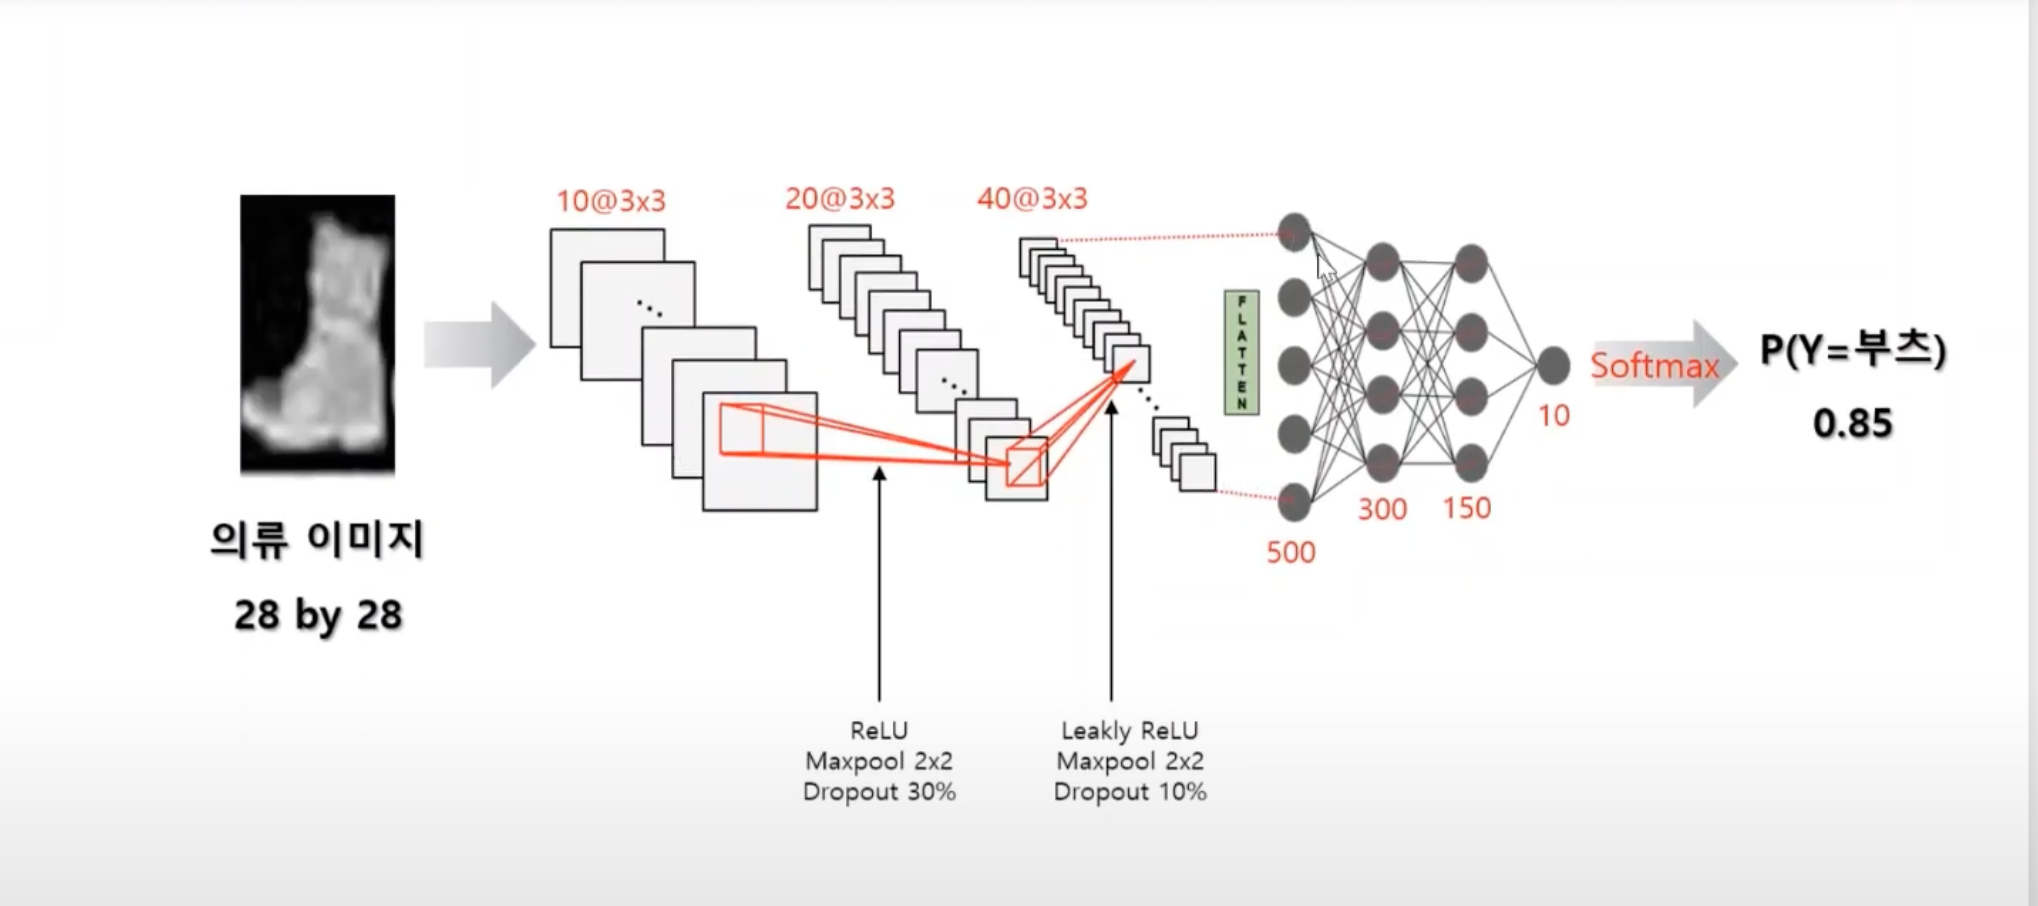


In [ ]:
from torch.nn.modules.linear import Linear
class CNN(pl.LightningModule):
    def __init__(self, class_num):
        super().__init__()

        #Convolution
       
        self.conv1 = nn.Conv2d(1,10,(3,3)) #3*3 커널10개를 이용해서 cnn convolution 연산. 
        self.conv2 = nn.Conv2d(10,20,(3,3))
        self.conv3 = nn.Conv2d(20,40,(3,3))

        #pooling layer
        self.max_pool = nn.MaxPool2d((2,2),2)

        #dropout
        self.dropout_1 = nn.Dropout(p = 0.3)
        self.dropout_2 = nn.Dropout(p = 0.1)

        #activation funtion
        self.relu = nn.ReLU(inplace = True)
        self.lrelu = nn.LeakyReLU(negative_slope= 0.1, inplace = True)

        #classifier
        #cnn 구조를 구축. 위의 사진과 같은 cnn을 생성함.
        self.classifier = nn.Sequential(nn.Linear(500,300),
                                        self.relu,
                                        self.dropout_1,
                                        nn.Linear(300,100),
                                        self.lrelu,
                                        self.dropout_2,
                                        nn.Linear(100,class_num))
        
        # for logging #로그를 작성해가면서 로스, acc 파악 가능. 오버, 언더피팅을 확인하면서 멈출지점 확인 가능.
        self.train_loss_ = []
        self.train_acc_ =[]
        self.val_loss_ =[]
        self.val_acc_=[]

        #for convenient
        self.class_num = class_num
    def forward(self,x): # x is input data

      # x >>> convolution >>> relu >>> max_pool >>> dropout
      x = self.conv1(x)
      x = self.relu(x)
      x = self.max_pool(x)
      x = self.dropout_1(x)


      # ... >>> convolution >>> relu >>> max_pool >>> dropout

      x = self.conv2(x)
      x = self.lrelu(x)
      x = self.max_pool(x)
      x = self.dropout_2(x)

      #여기까지 2차 convolution 연산하고 500개의 입력값까지 생성 되었음. 이제 flatten한 벡터로 만들어서 입력해주기.


      # ... >>> classifier >>> logit
      flatten = x.view(x.size(0),-1)
      logit = self.classifier(flatten)

      return logit

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr = 0.001) #learning rate

      return optimizer

    def training_step(self,batch,batch_idx):
      x, y = batch # 배치 단위의 데이터를 어느 패키지에서?
      logit = self(x) #self(x) 는 model(input)으로 이해하기
      prob = F.softmax(logit,dim = 1)
      train_accuracy = FM.accuracy(prob, y)
      loss = F.cross_entropy(logit,y)
      logs = {'train_loss':loss, 'train_acc':train_accuracy}
      result = {'loss': loss, 'log':logs, 'train_acc':train_accuracy}

      return result

    def training_epoch_end(self,result):

      avg_loss = torch.stack([x['loss'] for x in result]).mean()
      avg_acc = torch.stack([x['train_acc'] for x in result]).mean()
      epoch_result = {'loss':avg_loss, 'train_acc':avg_acc}
      self.train_loss_.append(avg_loss.cpu().numpy().item())
      self.train_acc_.append(avg_acc.cpu().numpy().item())

      return epoch_result

    def validation_step(self, batch, batch_idx):
      x, y = batch 
      y_hat = self(x)
      y_hat_prob = F.softmax(y_hat,dim = 1)
      val_accuracy = FM.accuracy(y_hat_prob,y)
      val_loss = F.cross_entropy(y_hat, y)
      logs = {'val_accuracy': val_accuracy, 'val_loss':val_loss}
      result = {'loss':val_loss, 'log':logs, 'val_acc':val_accuracy}

      return result

    def validation_epoch_end(self, result):
      avg_loss = torch.stack([x['loss'] for x in result]).mean()
      avg_acc = torch.stack([x['val_acc'] for x in result]).mean()
      epoch_result = {'loss':avg_loss, 'acc':avg_acc}
      self.val_loss_.append(avg_loss.cpu().numpy().item())
      self.val_acc_.append(avg_acc.cpu().numpy().item())
      self.log('val_accuracy',avg_acc)

      return epoch_result

    def test_step(self, batch, batch_idx):
      x, y = batch
      y_hat = self(x)
      y_hat_prob = F.softmax(y_hat, dim=1)
      result = {'predicted':y_hat_prob, 'target':y}

      return result

    def test_epoch_end(self, result):
      predicted = torch.stack([x['predicted'] for x in result])
      predicted = predicted.view(-1, self.class_num)
      target = torch.stack([x['target'] for x in result])
      target = target.view(-1)

      self.test_predicted = predicted.detach().cpu().numpy()
      self.test_target = target.detach().cpu().numpy()




    


In [ ]:
class CNN(pl.LightningModule):
  def __init__(self, class_num):
    super().__init__()

    # convolution
    self.conv1 = nn.Conv2d(1,10,(3,3)) #첫번째 필터 3*3 필터를 10개 가진 cnn convolution 연산 >> 3D도 가능할 것.(Conv3d)
    self.conv2 = nn.Conv2d(10,20,(3,3))
    self.conv3 = nn.Conv2d(20,40,(3,3))

    #pooling layer
    self.max_pool = nn.MaxPool2d((2,2),2)

    #dropout
    self.dropout_1 = nn.Dropout(p=0.3)
    self.dropout_2 = nn.Dropout(p=0.1)

    #activation function
    self.relu = nn.ReLU(inplace=True)
    self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)

    #clasifier
    self.classifier = nn.Sequential(nn.Linear(500,300),
                                    self.relu,
                                    self.dropout_1,
                                    nn.Linear(300,100),
                                    self.lrelu,
                                    self.dropout_2,
                                    nn.Linear(100, class_num))
    #여기까지 CNN 구조 정의

    #for logging - 학습이 잘 되고 있는지 관찰하기 위해서 데이터 수집 (오버피팅, 언더피팅 파악할 수 있음.)
    self.train_loss_ = []
    self.train_acc_ = []
    self.val_loss_ = []
    self.val_acc_ = []

    #for convenient
    self.class_num = class_num

  def forward (self, x): # x is input data
    # x -> convolution -> relu -> max_pool -> dropout
    x = self.conv1(x)
    x = self.relu(x)
    x = self.max_pool(x)
    x = self.dropout_1(x)

    # .. -> convolution -> relu -> max_pool -> dropout
    x = self.conv2(x)
    x = self.relu(x)
    x = self.max_pool(x)
    x = self.dropout_2(x)

    #여기까지가 x라는 데이터를 입력 받았을 때 Platten 과정까지.

    # . -> classifier -> logit
    flatten = x.view(x.size(0),-1)
    logit = self.classifier(flatten)

    return logit

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr = 0.001) #lr : learning rate
    return optimizer

  def training_step(self, batch, batch_idx):
    x, y = batch # 배치 단위의 데이터가 준비되어 있음
    logit = self(x) # self(x)는 model(input)와 같다고 이해하면 된다.>> model에 x를 입력했다.
    prob = F.softmax(logit, dim=1)
    train_accuracy = FM.accuracy(prob, y)
    loss = F.cross_entropy(logit,y)
    logs = {'train_loss':loss, 'train_acc':train_accuracy}
    result = {'loss':loss, 'log':logs, 'train_acc':train_accuracy}
    return result

  def training_epoch_end(self,result):
    avg_loss = torch.stack([x['loss'] for x in result]).mean()
    avg_acc = torch.stack([x['train_acc'] for x in result]).mean()
    epoch_result = {'loss':avg_loss, 'train_acc':avg_acc}
    self.train_loss_.append(avg_loss.cpu().numpy().item())
    self.train_acc_.append(avg_acc.cpu().numpy().item())
    #return epoch_result

  def validation_step(self,batch,batch_idx):
    x, y = batch # validation 데이터의 배치
    y_hat = self(x)
    y_hat_prob = F.softmax(y_hat, dim=1)
    val_accuracy = FM.accuracy(y_hat_prob,y)
    val_loss = F.cross_entropy(y_hat, y)
    logs = {'val_accuracy':val_accuracy, 'val_loss':val_loss}
    result = {'loss':val_loss, 'log':logs, 'val_acc':val_accuracy}
    return result

  def validation_epoch_end(self, result):
    avg_loss = torch.stack([x['loss'] for x in result]).mean()
    avg_acc = torch.stack([x['val_acc'] for x in result]).mean()
    epoch_result = {'loss':avg_loss, 'acc':avg_acc}
    self.val_loss_.append(avg_loss.cpu().numpy().item())
    self.val_acc_.append(avg_acc.cpu().numpy().item())
    self.log('val_accuracy',avg_acc)
    return epoch_result

  def test_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    y_hat_prob = F.softmax(y_hat, dim=1)
    result = {'predicted':y_hat_prob, 'target':y}
    return result

  def test_epoch_end(self, result):
    predicted = torch.stack([x['predicted'] for x in result])
    predicted = predicted.view(-1, self.class_num)
    target = torch.stack([x['target'] for x in result])
    target = target.view(-1)

    self.test_predicted = predicted.detach().cpu().numpy()
    self.test_target = target.detach().cpu().numpy()


In [ ]:
start = time.time() # 모델 학습 시작 시간 저장
cnn = CNN(class_num=10)
early_stop = EarlyStopping(monitor = 'val_accuracy', patience=5, verbose = True, mode='max') # val_accuracy가 5번이상 연속으로 증가하지 않을 때 종료.
checkpoint = ModelCheckpoint(filename='./CNN-{epoch}-{val_accuracy}',monitor='val_accuracy',mode='max',save_top_k=1)
trainer = pl.Trainer(callbacks=[early_stop, checkpoint],gpus=1) #gpu 있으면 1로, 없으면 0으로 
trainer.fit(cnn,train_loader,valid_loader)
print("time :", time.time() - start) #학습시간 프린트

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | conv1      | Conv2d     | 100   
1 | conv2      | Conv2d     | 1.8 K 
2 | conv3      | Conv2d     | 7.2 K 
3 | max_pool   | MaxPool2d  | 0     
4 | dropout_1  | Dropout    | 0     
5 | dropout_2  | Dropout    | 0     
6 | relu       | ReLU       | 0     
7 | lrelu      | LeakyReLU  | 0     
8 | classifier | Sequential | 181 K 
------------------------------------------
190 K     Trainable params
0         Non-trainable params
190 K     Total params
0.762     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved. New best score: 0.794


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.028 >= min_delta = 0.0. New best score: 0.822


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.021 >= min_delta = 0.0. New best score: 0.843


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.014 >= min_delta = 0.0. New best score: 0.857


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.867


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.873


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.878


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.881


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.885


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.888


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.891


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.894


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.894


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.897


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.899


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.901


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.903


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.904


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.904


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.906


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.906


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.908


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_accuracy did not improve in the last 5 records. Best score: 0.908. Signaling Trainer to stop.


time : 382.463365316391


### DNN

In [ ]:
class DNN(pl.LightningModule):
  def __init__(self, class_num):
    super().__init__()

    #dropout
    self.dropout_1 = nn.Dropout(p=0.3)
    self.dropout_2 = nn.Dropout(p=0.1)

    #activation function
    self.relu = nn.ReLU(inplace=True)
    self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)

    #clasifier
    self.classifier = nn.Sequential(nn.Linear(28*28, 300), # 28*28 데이터 변수를 입력 받아서 300차원으로 forwarding
                                    self.relu,
                                    self.dropout_1,
                                    nn.Linear(300,100),
                                    self.lrelu,
                                    self.dropout_2,
                                    nn.Linear(100, class_num))
    
    #for logging
    self.train_loss_ = []
    self.train_acc_ = []
    self.val_loss_ = []
    self.val_acc_ = []

    #for convenient
    self.class_num = class_num

  def forward(self, x): # x is input data
    # x -> classifier -> logit
    flatten = x.view(x.size(0),-1)
    logit = self.classifier(flatten)
    
    return logit

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
    return optimizer

  def training_step(self, batch, batch_idx):
    x, y = batch
    logit = self(x)
    prob = F.softmax(logit, dim=1)
    train_accuracy = FM.accuracy(prob, y)
    loss = F.cross_entropy(logit,y)
    logs = {'train_loss':loss, 'train_acc':train_accuracy}
    result = {'loss':loss, 'log':logs, 'train_acc':train_accuracy}
    return result

  def training_epoch_end(self,result):
    avg_loss = torch.stack([x['loss'] for x in result]).mean()
    avg_acc = torch.stack([x['train_acc'] for x in result]).mean()
    epoch_result = {'loss':avg_loss, 'train_acc':avg_acc}
    self.train_loss_.append(avg_loss.cpu().numpy().item())
    self.train_acc_.append(avg_acc.cpu().numpy().item())
    #return epoch_result

  def validation_step(self,batch,batch_idx):
    x, y = batch # validation 데이터의 배치
    y_hat = self(x)
    y_hat_prob = F.softmax(y_hat, dim=1)
    val_accuracy = FM.accuracy(y_hat_prob,y)
    val_loss = F.cross_entropy(y_hat, y)
    logs = {'val_accuracy':val_accuracy, 'val_loss':val_loss}
    result = {'loss':val_loss, 'log':logs, 'val_acc':val_accuracy}
    return result

  def validation_epoch_end(self, result):
    avg_loss = torch.stack([x['loss'] for x in result]).mean()
    avg_acc = torch.stack([x['val_acc'] for x in result]).mean()
    epoch_result = {'loss':avg_loss, 'acc':avg_acc}
    self.val_loss_.append(avg_loss.cpu().numpy().item())
    self.val_acc_.append(avg_acc.cpu().numpy().item())
    self.log('val_accuracy',avg_acc)
    return epoch_result

  def test_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    y_hat_prob = F.softmax(y_hat, dim=1)
    result = {'predicted':y_hat_prob, 'target':y}
    return result

  def test_epoch_end(self, result):
    predicted = torch.stack([x['predicted'] for x in result])
    predicted = predicted.view(-1, self.class_num)
    target = torch.stack([x['target'] for x in result])
    target = target.view(-1)

    self.test_predicted = predicted.detach().cpu().numpy()
    self.test_target = target.detach().cpu().numpy()

In [ ]:
start = time.time() # 모델 학습 시작 시간 저장
dnn = DNN(class_num=10)
early_stop = EarlyStopping(monitor = 'val_accuracy', patience=5, verbose = True, mode='max') # Early stopping
checkpoint = ModelCheckpoint(filename='./DNN-{epoch}-{val_accuracy}',monitor='val_accuracy',mode='max',save_top_k=1) #Model Parameter Save
trainer = pl.Trainer(callbacks=[early_stop, checkpoint],gpus=1)
trainer.fit(dnn,train_loader,valid_loader)
print("time :", time.time() - start) #학습 소요 시간 출력

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | dropout_1  | Dropout    | 0     
1 | dropout_2  | Dropout    | 0     
2 | relu       | ReLU       | 0     
3 | lrelu      | LeakyReLU  | 0     
4 | classifier | Sequential | 266 K 
------------------------------------------
266 K     Trainable params
0         Non-trainable params
266 K     Total params
1.066     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved. New best score: 0.846


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.018 >= min_delta = 0.0. New best score: 0.864


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.871


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.872


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.876


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.878


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.881


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.882


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.883


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.889


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.892


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.892


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.896


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_accuracy did not improve in the last 5 records. Best score: 0.896. Signaling Trainer to stop.


time : 334.4278156757355


## 3-3. 학스

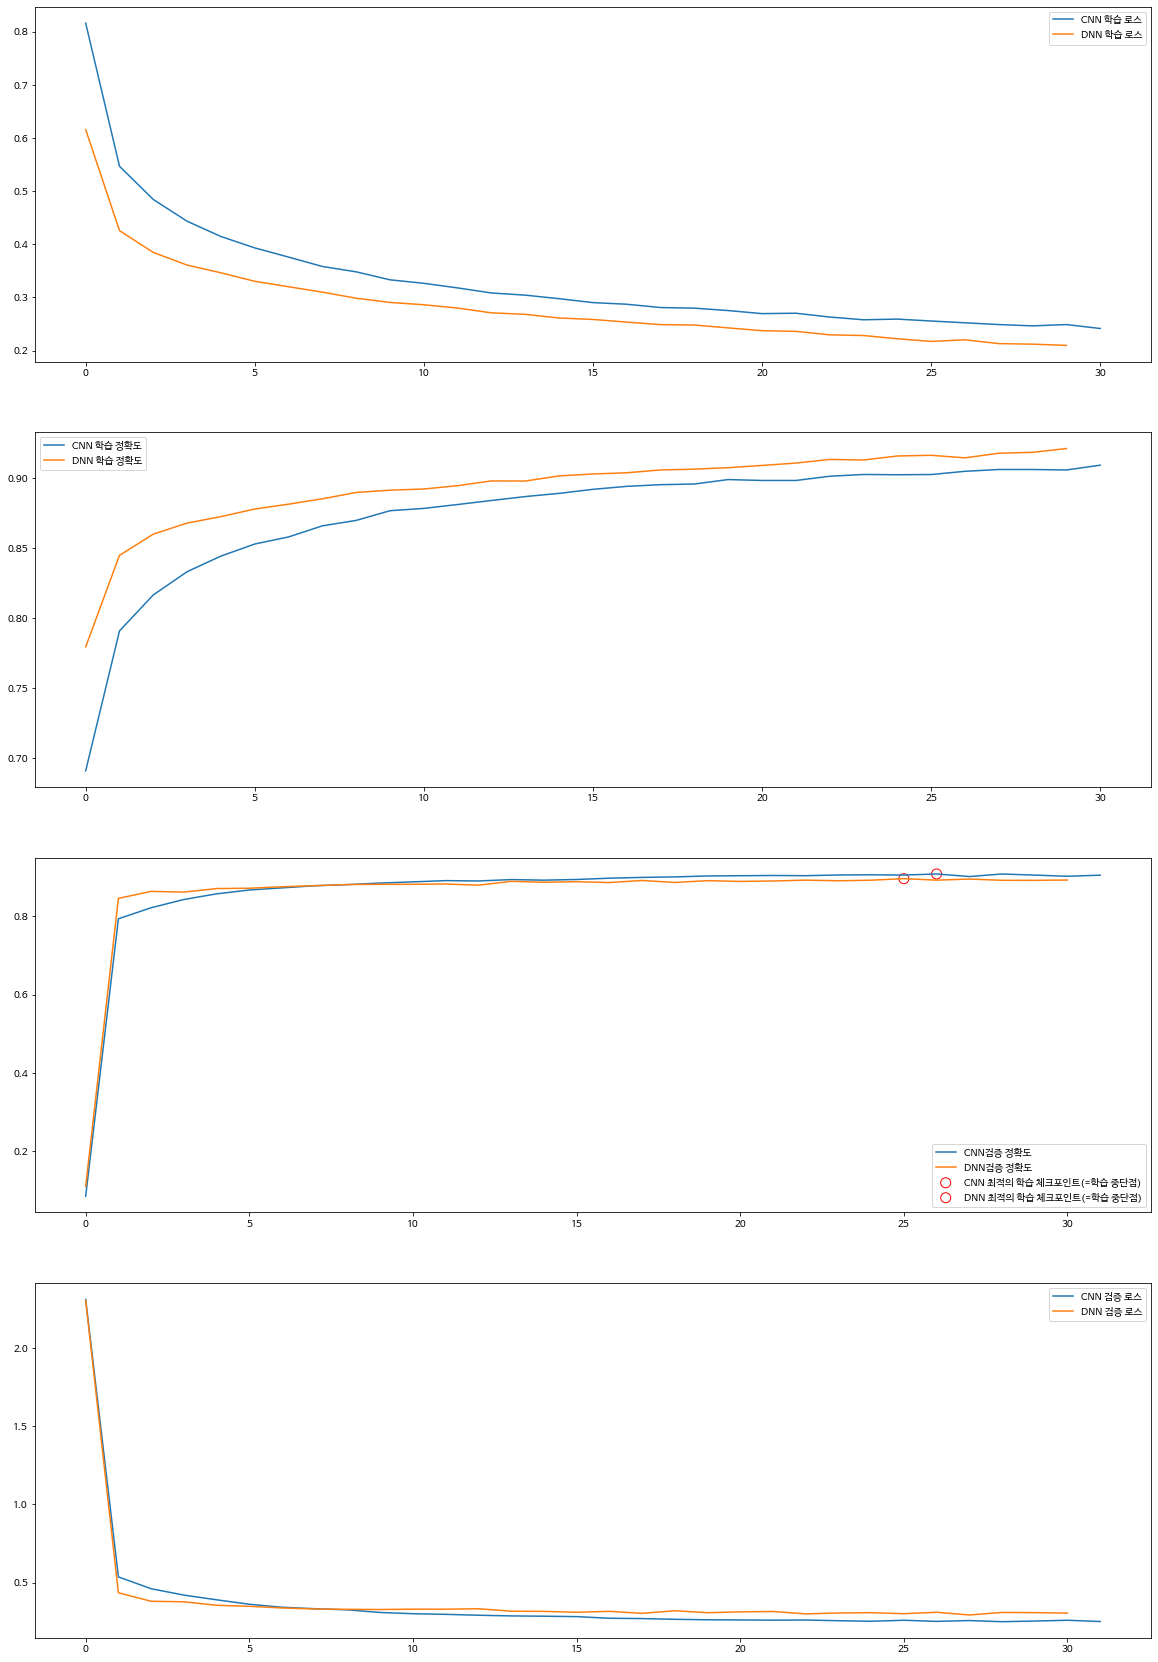

In [ ]:
# CNN logs
cnn_train_loss = cnn. train_loss_
cnn_train_acc = cnn.train_acc_
cnn_valid_loss = cnn.val_loss_
cnn_valid_acc = cnn.val_acc_

# DNN logs
dnn_train_loss = dnn.train_loss_
dnn_train_acc = dnn.train_acc_
dnn_valid_loss = dnn.val_loss_
dnn_valid_acc = dnn.val_acc_

# 그래프 배경화면 만들기
f, axs = plt.subplots(4,1,figsize=(20,30))

# 학습로스 변동 관찰하기
axs[0].plot(cnn_train_loss,label = 'CNN 학습 로스')
axs[0].plot(dnn_train_loss,label = 'DNN 학습 로스')
axs[0].legend()

# 학습 정확도 변동 관찰하기
axs[1].plot(cnn_train_acc,label = 'CNN 학습 정확도')
axs[1].plot(dnn_train_acc,label = 'DNN 학습 정확도')
axs[1].legend()

# 검증용 데이터에 대한 Accuracy 변동 관찰하기
axs[2].plot(cnn_valid_acc, label = 'CNN검증 정확도')
axs[2].scatter(np.argmax(cnn_valid_acc),np.max(cnn_valid_acc),s=100, facecolors = 'none', edgecolors='r',
               label = 'CNN 최적의 학습 체크포인트(=학습 중단점)')
axs[2].plot(dnn_valid_acc, label = 'DNN검증 정확도')
axs[2].scatter(np.argmax(dnn_valid_acc),np.max(dnn_valid_acc),s=100, facecolors = 'none', edgecolors='r',
               label = 'DNN 최적의 학습 체크포인트(=학습 중단점)')
axs[2].legend()

# 검증용 데이터에 대한 loss 변동 관찰하기
axs[3].plot(cnn_valid_loss,label = 'CNN 검증 로스')
axs[3].plot(dnn_valid_loss,label = 'DNN 검증 로스')
axs[3].legend()

plt.show()

In [ ]:
# test Accuracy 확인하기

trainer.test(model=cnn, test_dataloaders = test_loader) #test data에 대한 예측 수행
trainer.test(model=dnn, test_dataloaders = test_loader) #test data에 대한 예측 수행

cnn_test_accuracy = accuracy_score(y_pred=cnn.test_predicted.argmax(1),y_true = cnn.test_target)
dnn_test_accuracy = accuracy_score(y_pred=dnn.test_predicted.argmax(1),y_true = dnn.test_target)
print(f"CNN 분류 정확도 : {cnn_test_accuracy:.3f}",f"DNN 분류 정확도: {dnn_test_accuracy: .3f}" , sep=' | ')

TypeError: ignored

In [ ]:
confusion_matrix_ = confusion_matrix(y_pred=cnn.test_predicted.argmax(1),y_true=cnn.test_target)
plot_confusion_matrix(cm = confusion_matrix_, classes=dataset.classes, title = 'CNN을 이용한 Fashion MNIST 예측 결과')

In [ ]:
# 테스트 데이터를 기준으로 각 테스트 데이터의 시각화, 실제 class, 예측 class, class를 예측하는 데 확률값
for_visualization_test_x = test_dataset.data.numpy()[:100] #10000개중 100개만 샘플링해서 시각화
for_visualization_test_y = test_dataset.targets.numpy()[:100]

f , axs = plt.subplots(10,10,figsize=(20,20))
plt.subplots_adjust(hspace=0.8) #그래프 사이 간격 조절
for i in range(10):
  for j in range(10):

    x_data = for_visualization_test_x[10*i+j]
    y_data = for_visualization_test_y[10*i+j]
    real_class = dataset.classes[y_data]
    predicted_class = dataset.classes[cnn.test_predicted[10*i+j].argmax()] # model.predict_proba : 입력받은 데이터의 예측 확률 값 출력 가능
    predicted_prob = cnn.test_predicted[10*i+j].max() # 어떤 확률값이 가장 컸는지

    # x,y 축의 지점 표시를 안함
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])

    # subplot의 제목을 i번째 결과에 해당하는 숫자로 설정
    axs[i,j].set_title(f"실제 class:{real_class}\n예측 class:{predicted_class}\nProbability:{predicted_prob: .2f}")

    # 입력으로 사용한 i번째 테스트 이미지를 28*28로 재배열하고
    # 이 2차원 배열을 그레이스케일 이미지로 출력
    axs[i,j].imshow(x_data.reshape((28,28)),cmap=plt.cm.gray_r)

plt.show()